In [ ]:
import pandas as pd

df = pd.read_json('/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/preprocessed_ads.json')
print(df.shape)

df.head()

(776, 5)


,Category,Title,Webindex,Company,Description
0,Engineering,Site Maintenance Engineer (ElectroMechanical),72635560,Rise Technical Recruitment,site maintenance electromechanical birmingham ...
1,Engineering,Inspector Sheet Metal,69145960,None,absolute acting behalf established contract sh...
2,Engineering,Graduate Recruitment Consultant,69267760,Akton Recruitment Ltd,graduate consultant location altrincham compet...
3,Engineering,Electronics Project Engineer,69265319,Progressive Recruitment,electronics project technology permanent oxfor...
4,Engineering,Signalling Design Engineer,69198249,Hays TCE Jobs,largest consultancies world signalling growing...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

In [ ]:
df.Category.value_counts()

Category
Engineering           231
Healthcare_Nursing    198
Accounting_Finance    191
Sales                 156
Name: count, dtype: int64

In [ ]:
min_samples = 156 # we have these many Sales job category and Sales is our minority class

df_Engineering = df[df.Category=="Engineering"].sample(min_samples, random_state=101)
df_Healthcare_Nursing = df[df.Category=="Healthcare_Nursing"].sample(min_samples, random_state=101)
df_Accounting_Finance = df[df.Category=="Accounting_Finance"].sample(min_samples, random_state=101)
df_Sales = df[df.Category=="Sales"].sample(min_samples, random_state=101)

In [ ]:
df_balanced = pd.concat([df_Engineering,df_Healthcare_Nursing,df_Accounting_Finance,df_Sales],axis=0)
df_balanced.Category.value_counts()

Category
Engineering           156
Healthcare_Nursing    156
Accounting_Finance    156
Sales                 156
Name: count, dtype: int64

In [ ]:
target = {'Engineering': 0, 'Healthcare_Nursing': 1, 'Accounting_Finance': 2, 'Sales': 3}

df_balanced['Category_num'] = df_balanced['Category'].map({
    'Engineering': 0,
    'Healthcare_Nursing': 1,
    'Accounting_Finance': 2,
    'Sales': 3
})

In [ ]:
df_balanced.head()

,Category,Title,Webindex,Company,Description,Category_num
127,Engineering,Welder,68700091,Avenue Scotland,mig tig weld carbon stainless steel previous e...,0
4,Engineering,Signalling Design Engineer,69198249,Hays TCE Jobs,largest consultancies world signalling growing...,0
167,Engineering,"Mechanical Draughtsman, Autodesk Inventor",71821372,JJ FOX,keywords autodesk inventor autocad draughtsman...,0
37,Engineering,Manufacturing / Operations / Outsourcing Direc...,71619468,None,international manufacturing operations outsour...,0
121,Engineering,Graduate Sales Engineer (Machine and Consumables),72406398,Omega Resource Group,graduate machine consumables ote fully expense...,0


1: Model Building Using Count Vectorizer

Model Training using only description of job advertisement

In [ ]:
df_balanced['Preprocessed_Description'] = df_balanced['Description'].apply(preprocess)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Description,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

In [ ]:
print(X_train.shape)
X_train.head()

(499,)


587    experience finance analyst large retail multi ...
433    core responsibility part executive drive part ...
135    seek principal fpga defence previous defence m...
237    social opportunity social worker learn disabil...
240    friendly energetic dedicated worker offer pers...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_train.value_counts()

Category_num
2    125
0    125
1    125
3    124
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Category_num
3    32
2    31
0    31
1    31
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

MultinomialNB Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams or bigrams or trigrams
    'vectorizer_bow__max_df': [0.75, 1.0],           # Maximum document frequency
    'multi_nb__alpha': [0.1, 1.0, 10.0]              # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'multi_nb__alpha': 0.1, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.94      0.94      0.94        31
           2       0.88      0.90      0.89        31
           3       0.75      0.84      0.79        32

    accuracy                           0.86       125
   macro avg       0.87      0.86      0.87       125
weighted avg       0.87      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Loistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 0.01, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        31
           1       0.88      0.94      0.91        31
           2       0.88      0.90      0.89        31
           3       0.79      0.84      0.82        32

    accuracy                           0.87       125
   macro avg       0.88      0.87      0.87       125
weighted avg       0.88      0.87      0.87       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

SVM Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 0.1, 'svc__kernel': 'linear', 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.85      0.94      0.89        31
           2       0.90      0.84      0.87        31
           3       0.78      0.88      0.82        32

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': None, 'random_forest__n_estimators': 500, 'vectorizer_bow__max_df': 1.0, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        31
           1       0.94      0.94      0.94        31
           2       0.87      0.84      0.85        31
           3       0.79      0.84      0.82        32

    accuracy                           0.86       125
   macro avg       0.87      0.86      0.86       125
weighted avg       0.87      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Gradient Boosting Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('gradient_boost', GradientBoostingClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'gradient_boost__n_estimators': [50, 100, 200],
    'gradient_boost__learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'gradient_boost__learning_rate': 0.2, 'gradient_boost__n_estimators': 200, 'vectorizer_bow__max_df': 1.0, 'vectorizer_bow__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        31
           1       0.85      0.94      0.89        31
           2       0.72      0.90      0.80        31
           3       0.85      0.69      0.76        32

    accuracy                           0.81       125
   macro avg       0.82      0.81      0.81       125
weighted avg       0.82      0.81      0.81       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

KNN Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('knn', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.41      0.81      0.54        31
           1       0.65      0.71      0.68        31
           2       0.78      0.23      0.35        31
           3       0.52      0.34      0.42        32

    accuracy                           0.52       125
   macro avg       0.59      0.52      0.50       125
weighted avg       0.59      0.52      0.50       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 1, 1, 0, 0])

Adaptive Boosting Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('adaboost', AdaBoostClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 100, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.83      0.48      0.61        31
           1       0.92      0.71      0.80        31
           2       0.49      0.87      0.63        31
           3       0.75      0.66      0.70        32

    accuracy                           0.68       125
   macro avg       0.75      0.68      0.69       125
weighted avg       0.75      0.68      0.69       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 2, 1, 0, 2])

In [ ]:
# !pip install tensorflow
!pip install keras

Deep Learning Models

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, SimpleRNN, SpatialDropout1D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Maximum number of words in the vocabulary
max_words = 5200
# Maximum length of the sequences
max_len = 100

In [ ]:
# Vectorize the text data
vectorizer = CountVectorizer(max_features=max_words)
X_train_counts = vectorizer.fit_transform(X_train).toarray()
X_test_counts = vectorizer.transform(X_test).toarray()

In [ ]:
# Pad the sequences
X_train_padded = pad_sequences(X_train_counts, maxlen=max_len)
X_test_padded = pad_sequences(X_test_counts, maxlen=max_len)

In [ ]:
# Function to create a simple neural network model
def create_dnn_model():
    model = Sequential()
    model.add(Dense(512, input_shape=(max_len,), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Function to create a CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Function to create an RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(np.unique(y_train_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Artificial NN Model

In [ ]:
# Train and evaluate the DNN model
dnn_model = create_dnn_model()
dnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_dnn_prob = dnn_model.predict(X_test_padded)
y_pred_dnn = np.argmax(y_pred_dnn_prob, axis=1)
print("DNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_dnn))

Epoch 1/5
16/16 [==============================] - 4s 13ms/step - loss: 1.3540 - accuracy: 0.3267
Epoch 2/5
16/16 [==============================] - 0s 19ms/step - loss: 1.2228 - accuracy: 0.4669
Epoch 3/5
16/16 [==============================] - 0s 16ms/step - loss: 1.1311 - accuracy: 0.5110
Epoch 4/5
16/16 [==============================] - 0s 10ms/step - loss: 1.0705 - accuracy: 0.5331
Epoch 5/5
4/4 [==============================] - 0s 6ms/step
DNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.35      0.43        31
           1       0.56      0.58      0.57        31
           2       0.35      0.52      0.42        31
           3       0.48      0.41      0.44        32

    accuracy                           0.46       125
   macro avg       0.49      0.46      0.46       125
weighted avg       0.49      0.46      0.46       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 2, 1, 0, 2])

Convolutional NN Model

In [ ]:
# Train and evaluate the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_cnn_prob = cnn_model.predict(X_test_padded)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)
print("CNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn))

Epoch 1/5
16/16 [==============================] - 2s 44ms/step - loss: 1.3925 - accuracy: 0.2305
Epoch 2/5
16/16 [==============================] - 1s 42ms/step - loss: 1.3857 - accuracy: 0.2525
Epoch 3/5
16/16 [==============================] - 1s 80ms/step - loss: 1.3833 - accuracy: 0.2766
Epoch 4/5
16/16 [==============================] - 2s 107ms/step - loss: 1.3814 - accuracy: 0.2806
Epoch 5/5
4/4 [==============================] - 0s 13ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.06        31
           1       0.33      0.26      0.29        31
           2       0.00      0.00      0.00        31
           3       0.29      0.88      0.44        32

    accuracy                           0.30       125
   macro avg       0.24      0.29      0.20       125
weighted avg       0.24      0.30      0.20       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 2, 1, 0, 2])

Recurrent NN Model

In [ ]:
# Train and evaluate the RNN model
rnn_model = create_rnn_model()
rnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_rnn_prob = rnn_model.predict(X_test_padded)
y_pred_rnn = np.argmax(y_pred_rnn_prob, axis=1)
print("RNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_rnn))

Epoch 1/5
16/16 [==============================] - 4s 61ms/step - loss: 1.3794 - accuracy: 0.2986
Epoch 2/5
16/16 [==============================] - 1s 44ms/step - loss: 1.3454 - accuracy: 0.3467
Epoch 3/5
16/16 [==============================] - 1s 41ms/step - loss: 1.3292 - accuracy: 0.3567
Epoch 4/5
16/16 [==============================] - 1s 41ms/step - loss: 1.3251 - accuracy: 0.3487
Epoch 5/5
4/4 [==============================] - 0s 13ms/step
RNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.42      0.39        31
           1       0.73      0.26      0.38        31
           2       0.15      0.13      0.14        31
           3       0.36      0.59      0.45        32

    accuracy                           0.35       125
   macro avg       0.40      0.35      0.34       125
weighted avg       0.40      0.35      0.34       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 2, 1, 0, 2])

In [5]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm")

def preprocess_title(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_.lower())

    return " ".join(filtered_tokens)

Model Training using only title of job advertisement

In [ ]:
df_balanced['Preprocessed_Title'] = df_balanced['Title'].apply(preprocess_title)

In [ ]:
df_balanced.head()

,Category,Title,Webindex,Company,Description,Category_num,Preprocessed_Description,Preprocessed_Title
127,Engineering,Welder,68700091,Avenue Scotland,mig tig weld carbon stainless steel previous e...,0,mig tig weld carbon stainless steel previous e...,welder
4,Engineering,Signalling Design Engineer,69198249,Hays TCE Jobs,largest consultancies world signalling growing...,0,large consultancy world signal grow glasgow ra...,signal design engineer
167,Engineering,"Mechanical Draughtsman, Autodesk Inventor",71821372,JJ FOX,keywords autodesk inventor autocad draughtsman...,0,keywords autodesk inventor autocad draughtsman...,mechanical draughtsman autodesk inventor
37,Engineering,Manufacturing / Operations / Outsourcing Direc...,71619468,None,international manufacturing operations outsour...,0,international manufacturing operation outsourc...,manufacturing operations outsourcing director ...
121,Engineering,Graduate Sales Engineer (Machine and Consumables),72406398,Omega Resource Group,graduate machine consumables ote fully expense...,0,graduate machine consumable ote fully expense ...,graduate sales engineer machine consumables


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Title,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

In [ ]:
print(X_train.shape)
X_train.head()

(499,)


587          finance analyst
433    parts sales executive
135    principal fpga design
237           social workers
240      home support worker
Name: Preprocessed_Title, dtype: object

In [ ]:
y_train.value_counts()

Category_num
2    125
0    125
1    125
3    124
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Category_num
3    32
2    31
0    31
1    31
Name: count, dtype: int64

MultinomialNB Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams or bigrams or trigrams
    'vectorizer_bow__max_df': [0.75, 1.0],           # Maximum document frequency
    'multi_nb__alpha': [0.1, 1.0, 10.0]              # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'multi_nb__alpha': 0.1, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.88      0.68      0.76        31
           1       0.79      0.87      0.83        31
           2       0.83      0.77      0.80        31
           3       0.74      0.88      0.80        32

    accuracy                           0.80       125
   macro avg       0.81      0.80      0.80       125
weighted avg       0.81      0.80      0.80       125



In [ ]:
X_test[:5]

646        financial analystbelfast****k
27     transport planner taunton     ben
344          community rmn west midlands
14                metal detection expert
36                    qa section manager
Name: Preprocessed_Title, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 3])

Logistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 10, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.90      0.61      0.73        31
           1       0.87      0.84      0.85        31
           2       0.72      0.90      0.80        31
           3       0.74      0.81      0.78        32

    accuracy                           0.79       125
   macro avg       0.81      0.79      0.79       125
weighted avg       0.81      0.79      0.79       125



In [ ]:
X_test[:5]

646        financial analystbelfast****k
27     transport planner taunton     ben
344          community rmn west midlands
14                metal detection expert
36                    qa section manager
Name: Preprocessed_Title, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 2, 0, 2])

SVM Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 10, 'svc__kernel': 'linear', 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.90      0.58      0.71        31
           1       0.87      0.84      0.85        31
           2       0.68      0.90      0.78        31
           3       0.76      0.81      0.79        32

    accuracy                           0.78       125
   macro avg       0.80      0.78      0.78       125
weighted avg       0.80      0.78      0.78       125



In [ ]:
X_test[:5]

646        financial analystbelfast****k
27     transport planner taunton     ben
344          community rmn west midlands
14                metal detection expert
36                    qa section manager
Name: Preprocessed_Title, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 2, 0, 2])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': None, 'random_forest__n_estimators': 50, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.90      0.61      0.73        31
           1       0.92      0.77      0.84        31
           2       0.65      0.84      0.73        31
           3       0.68      0.81      0.74        32

    accuracy                           0.76       125
   macro avg       0.79      0.76      0.76       125
weighted avg       0.79      0.76      0.76       125



In [ ]:
X_test[:5]

646        financial analystbelfast****k
27     transport planner taunton     ben
344          community rmn west midlands
14                metal detection expert
36                    qa section manager
Name: Preprocessed_Title, dtype: object

In [ ]:
y_pred[:5]

array([2, 2, 2, 3, 0])

Model Training using both title and description of job advertisement

In [ ]:
df_balanced['Preprocessed_Title_Description']=df_balanced['Preprocessed_Title']+ " " + df_balanced['Preprocessed_Description']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Title_Description,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

In [ ]:
print(X_train.shape)
X_train.head()

(499,)


587    finance analyst experience finance analyst lar...
433    parts sales executive core responsibility part...
135    principal fpga design seek principal fpga defe...
237    social workers social opportunity social worke...
240    home support worker friendly energetic dedicat...
Name: Preprocessed_Title_Description, dtype: object

In [ ]:
y_train.value_counts()

Category_num
2    125
0    125
1    125
3    124
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Category_num
3    32
2    31
0    31
1    31
Name: count, dtype: int64

MultiNomialNB Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, bigrams, trigrams,
    'vectorizer_bow__max_df': [0.5, 0.75, 0.85, 1.0],         # Maximum document frequency
    'vectorizer_bow__min_df': [0.01, 0.05, 0.1],              # Minimum document frequency
    'multi_nb__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0] # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'multi_nb__alpha': 0.1, 'vectorizer_bow__max_df': 0.5, 'vectorizer_bow__min_df': 0.01, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.94      0.94      0.94        31
           2       0.87      0.87      0.87        31
           3       0.78      0.88      0.82        32

    accuracy                           0.87       125
   macro avg       0.88      0.87      0.87       125
weighted avg       0.88      0.87      0.87       125



In [ ]:
from joblib import dump,load

best_vectorizer = grid_search.best_estimator_.named_steps['vectorizer_bow']
dump(best_vectorizer, '/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/vectorizer_count.pkl')

['/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/vectorizer_count.pkl']

In [ ]:
dump(grid_search, '/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/MultinomialNB_CountVectorizer_model.joblib')

['/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/MultinomialNB_CountVectorizer_model.joblib']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[25,  0,  2,  4],
       [ 0, 29,  0,  2],
       [ 1,  1, 27,  2],
       [ 1,  1,  2, 28]])

Text(95.72222222222221, 0.5, 'Truth')

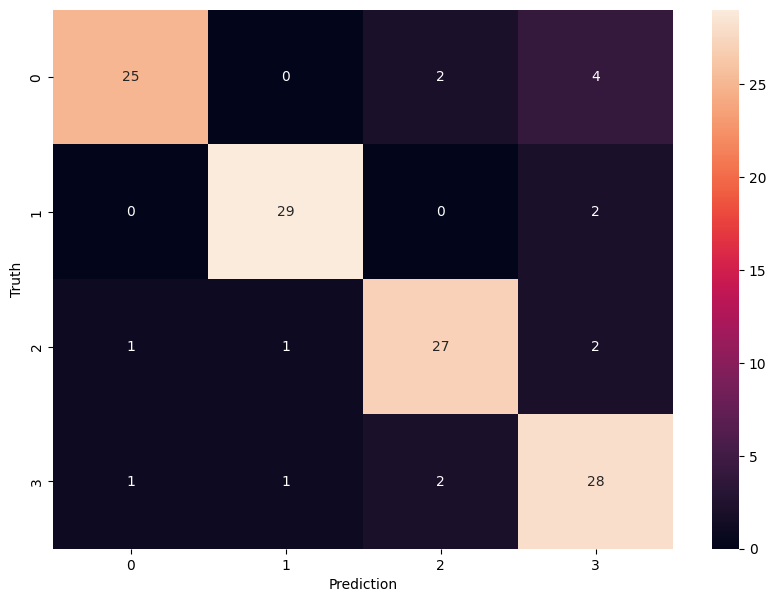

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [ ]:
X_test[:5]

646    financial analystbelfast****k analystbelfast b...
27     transport planner taunton     ben transport pl...
344    community rmn west midlands community rmn visi...
14     metal detection expert product specialist meta...
36     qa section manager qa section quality departme...
Name: Preprocessed_Title_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Logistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 0.01, 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.91      0.94      0.92        31
           2       0.85      0.90      0.88        31
           3       0.79      0.81      0.80        32

    accuracy                           0.87       125
   macro avg       0.88      0.87      0.87       125
weighted avg       0.88      0.87      0.87       125



In [ ]:
X_test[:5]

646    financial analystbelfast****k analystbelfast b...
27     transport planner taunton     ben transport pl...
344    community rmn west midlands community rmn visi...
14     metal detection expert product specialist meta...
36     qa section manager qa section quality departme...
Name: Preprocessed_Title_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

SVM Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 10, 'svc__kernel': 'rbf', 'vectorizer_bow__max_df': 0.75, 'vectorizer_bow__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.85      0.90      0.88        31
           2       0.84      0.84      0.84        31
           3       0.79      0.84      0.82        32

    accuracy                           0.84       125
   macro avg       0.84      0.84      0.84       125
weighted avg       0.84      0.84      0.84       125



In [ ]:
X_test[:5]

646    financial analystbelfast****k analystbelfast b...
27     transport planner taunton     ben transport pl...
344    community rmn west midlands community rmn visi...
14     metal detection expert product specialist meta...
36     qa section manager qa section quality departme...
Name: Preprocessed_Title_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 2, 0, 0])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_bow', CountVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_bow__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_bow__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': None, 'random_forest__n_estimators': 500, 'vectorizer_bow__max_df': 1.0, 'vectorizer_bow__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        31
           1       0.94      0.94      0.94        31
           2       0.81      0.94      0.87        31
           3       0.82      0.88      0.85        32

    accuracy                           0.87       125
   macro avg       0.88      0.87      0.87       125
weighted avg       0.88      0.87      0.87       125



In [ ]:
X_test[:5]

646    financial analystbelfast****k analystbelfast b...
27     transport planner taunton     ben transport pl...
344    community rmn west midlands community rmn visi...
14     metal detection expert product specialist meta...
36     qa section manager qa section quality departme...
Name: Preprocessed_Title_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

2 : Model Building Using using TF-IDF Vectorizer

Model Training using only the description of job advertisement

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Description,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

In [ ]:
print(X_train.shape)
X_train.head()

(499,)


587    experience finance analyst large retail multi ...
433    core responsibility part executive drive part ...
135    seek principal fpga defence previous defence m...
237    social opportunity social worker learn disabil...
240    friendly energetic dedicated worker offer pers...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_train.value_counts()

Category_num
2    125
0    125
1    125
3    124
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Category_num
3    32
2    31
0    31
1    31
Name: count, dtype: int64

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (499,)
Shape of X_test:  (125,)


MultinomialNB Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object for TF-IDF weighted
pipeline_tfidf = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid_tfidf = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams or bigrams or trigrams
    'vectorizer_tfidf__max_df': [0.75, 1.0],                   # Maximum document frequency
    'multi_nb__alpha': [0.1, 1.0, 10.0]                        # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search_tfidf.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found for TF-IDF: ", grid_search_tfidf.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred_tfidf = grid_search_tfidf.predict(X_test)

# Print the classification report
print("TF-IDF Weighted Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


Best parameters found for TF-IDF:  {'multi_nb__alpha': 0.1, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
TF-IDF Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.94      0.94      0.94        31
           2       0.82      0.87      0.84        31
           3       0.77      0.84      0.81        32

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Logistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 10, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.91      0.94      0.92        31
           2       0.87      0.87      0.87        31
           3       0.79      0.81      0.80        32

    accuracy                           0.86       125
   macro avg       0.87      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

SVM Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 1, 'svc__kernel': 'linear', 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.94      0.94      0.94        31
           2       0.87      0.87      0.87        31
           3       0.79      0.84      0.82        32

    accuracy                           0.88       125
   macro avg       0.88      0.88      0.88       125
weighted avg       0.88      0.88      0.88       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': 10, 'random_forest__n_estimators': 200, 'vectorizer_tfidf__max_df': 1.0, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        31
           1       0.88      0.94      0.91        31
           2       0.84      0.87      0.86        31
           3       0.84      0.81      0.83        32

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

KNN Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('knn', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8],
    'knn__weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        31
           1       0.91      0.94      0.92        31
           2       0.84      0.84      0.84        31
           3       0.75      0.75      0.75        32

    accuracy                           0.82       125
   macro avg       0.82      0.82      0.82       125
weighted avg       0.82      0.82      0.82       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Gradient Boosting Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('gradient_boost', GradientBoostingClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'gradient_boost__n_estimators': [50, 100, 200],
    'gradient_boost__learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'gradient_boost__learning_rate': 0.1, 'gradient_boost__n_estimators': 200, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        31
           1       0.82      0.90      0.86        31
           2       0.74      0.81      0.77        31
           3       0.82      0.72      0.77        32

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.77       125
weighted avg       0.78      0.78      0.77       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[0:5]

array([2, 0, 1, 0, 2])

Adaptive Boosting Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('adaboost', AdaBoostClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'adaboost__learning_rate': 0.01, 'adaboost__n_estimators': 200, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.70      0.52      0.59        31
           1       0.96      0.71      0.81        31
           2       0.43      0.77      0.55        31
           3       0.78      0.56      0.65        32

    accuracy                           0.64       125
   macro avg       0.72      0.64      0.65       125
weighted avg       0.72      0.64      0.65       125



In [ ]:
X_test[:5]

646    analystbelfast black fox solution represent fa...
27     transport planner taunton bens fantastic arise...
344    community rmn visit user home cannock annum hr...
14     product specialist metal detection car locatio...
36     qa section quality department benefit leiceste...
Name: Preprocessed_Description, dtype: object

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Artificial NN Model

In [ ]:
# Train and evaluate the DNN model
dnn_model = create_dnn_model()
dnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_dnn_prob = dnn_model.predict(X_test_padded)
y_pred_dnn = np.argmax(y_pred_dnn_prob, axis=1)
print("DNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_dnn))

Epoch 1/5
16/16 [==============================] - 3s 16ms/step - loss: 1.3511 - accuracy: 0.3307
Epoch 2/5
16/16 [==============================] - 0s 10ms/step - loss: 1.2180 - accuracy: 0.4629
Epoch 3/5
16/16 [==============================] - 0s 10ms/step - loss: 1.1361 - accuracy: 0.5010
Epoch 4/5
16/16 [==============================] - 0s 13ms/step - loss: 1.0733 - accuracy: 0.5130
Epoch 5/5
4/4 [==============================] - 0s 6ms/step
DNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.29      0.38        31
           1       0.55      0.58      0.56        31
           2       0.37      0.68      0.48        31
           3       0.42      0.25      0.31        32

    accuracy                           0.45       125
   macro avg       0.47      0.45      0.43       125
weighted avg       0.47      0.45      0.43       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Convolutional NN Model

In [ ]:
# Train and evaluate the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_cnn_prob = cnn_model.predict(X_test_padded)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)
print("CNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_cnn))

Epoch 1/5
16/16 [==============================] - 4s 82ms/step - loss: 1.3898 - accuracy: 0.2485
Epoch 2/5
16/16 [==============================] - 1s 77ms/step - loss: 1.3839 - accuracy: 0.3066
Epoch 3/5
16/16 [==============================] - 1s 80ms/step - loss: 1.3830 - accuracy: 0.2625
Epoch 4/5
16/16 [==============================] - 1s 55ms/step - loss: 1.3767 - accuracy: 0.2946
Epoch 5/5
4/4 [==============================] - 0s 14ms/step
CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.03      0.06        31
           1       1.00      0.03      0.06        31
           2       0.29      0.23      0.25        31
           3       0.30      0.91      0.45        32

    accuracy                           0.30       125
   macro avg       0.48      0.30      0.21       125
weighted avg       0.48      0.30      0.21       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Recurrent NN Model

In [ ]:
# Train and evaluate the RNN model
rnn_model = create_rnn_model()
rnn_model.fit(X_train_padded, y_train_encoded, epochs=5, batch_size=32, verbose=1)
y_pred_rnn_prob = rnn_model.predict(X_test_padded)
y_pred_rnn = np.argmax(y_pred_rnn_prob, axis=1)
print("RNN Model Classification Report:")
print(classification_report(y_test_encoded, y_pred_rnn))

Epoch 1/5
16/16 [==============================] - 6s 108ms/step - loss: 1.3893 - accuracy: 0.2585
Epoch 2/5
16/16 [==============================] - 1s 93ms/step - loss: 1.3651 - accuracy: 0.3106
Epoch 3/5
16/16 [==============================] - 1s 62ms/step - loss: 1.4010 - accuracy: 0.2405
Epoch 4/5
16/16 [==============================] - 1s 41ms/step - loss: 1.3952 - accuracy: 0.2645
Epoch 5/5
4/4 [==============================] - 0s 12ms/step
RNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        31
           2       0.20      0.42      0.27        31
           3       0.37      0.69      0.48        32

    accuracy                           0.28       125
   macro avg       0.14      0.28      0.19       125
weighted avg       0.14      0.28      0.19       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Model Training using only the title  of job advertisement

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Title,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

MultinomialNB Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object for TF-IDF weighted
pipeline_tfidf = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid_tfidf = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams or bigrams or trigrams
    'vectorizer_tfidf__max_df': [0.75, 1.0],                   # Maximum document frequency
    'multi_nb__alpha': [0.1, 1.0, 10.0]                        # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search_tfidf.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found for TF-IDF: ", grid_search_tfidf.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred_tfidf = grid_search_tfidf.predict(X_test)

# Print the classification report
print("TF-IDF Weighted Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


Best parameters found for TF-IDF:  {'multi_nb__alpha': 0.1, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
TF-IDF Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.76        31
           1       0.82      0.87      0.84        31
           2       0.84      0.84      0.84        31
           3       0.76      0.88      0.81        32

    accuracy                           0.82       125
   macro avg       0.82      0.82      0.81       125
weighted avg       0.82      0.82      0.81       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Loistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 10, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.95      0.61      0.75        31
           1       0.85      0.90      0.88        31
           2       0.81      0.84      0.83        31
           3       0.72      0.91      0.81        32

    accuracy                           0.82       125
   macro avg       0.83      0.82      0.81       125
weighted avg       0.83      0.82      0.81       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 3])

SVM Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 10, 'svc__kernel': 'rbf', 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.95      0.61      0.75        31
           1       0.82      0.90      0.86        31
           2       0.81      0.81      0.81        31
           3       0.72      0.91      0.81        32

    accuracy                           0.81       125
   macro avg       0.83      0.81      0.80       125
weighted avg       0.83      0.81      0.80       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 3])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': None, 'random_forest__n_estimators': 50, 'vectorizer_tfidf__max_df': 1.0, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.90      0.58      0.71        31
           1       0.96      0.74      0.84        31
           2       0.63      0.84      0.72        31
           3       0.70      0.88      0.78        32

    accuracy                           0.76       125
   macro avg       0.80      0.76      0.76       125
weighted avg       0.80      0.76      0.76       125



In [ ]:
y_pred[:5]

array([2, 2, 2, 2, 3])

KNN Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('knn', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8],
    'knn__weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'knn__n_neighbors': 4, 'knn__weights': 'distance', 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.91      0.68      0.78        31
           1       0.79      0.87      0.83        31
           2       0.77      0.74      0.75        31
           3       0.74      0.88      0.80        32

    accuracy                           0.79       125
   macro avg       0.80      0.79      0.79       125
weighted avg       0.80      0.79      0.79       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Model Training using both title and description of job advertisement

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.Preprocessed_Title_Description,
    df_balanced.Category_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=101,
    stratify=df_balanced.Category_num
)

MultinomialNB Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object for TF-IDF weighted
pipeline_tfidf = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('multi_nb', MultinomialNB())
])

# Define the parameter grid for hyperparameter tuning
param_grid_tfidf = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams or bigrams or trigrams
    'vectorizer_tfidf__max_df': [0.75, 1.0],                   # Maximum document frequency
    'multi_nb__alpha': [0.1, 1.0, 10.0]                        # Smoothing parameter
}

# Initialize GridSearchCV with cross-validation
grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid_tfidf, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search_tfidf.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found for TF-IDF: ", grid_search_tfidf.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred_tfidf = grid_search_tfidf.predict(X_test)

# Print the classification report
print("TF-IDF Weighted Classification Report:")
print(classification_report(y_test, y_pred_tfidf))


Best parameters found for TF-IDF:  {'multi_nb__alpha': 0.1, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
TF-IDF Weighted Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.94      0.94      0.94        31
           2       0.82      0.87      0.84        31
           3       0.77      0.84      0.81        32

    accuracy                           0.86       125
   macro avg       0.86      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Logistic Regression Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('log_reg', LogisticRegression(max_iter=1000))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'log_reg__C': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'log_reg__C': 10, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.91      0.94      0.92        31
           2       0.87      0.87      0.87        31
           3       0.79      0.81      0.80        32

    accuracy                           0.86       125
   macro avg       0.87      0.86      0.86       125
weighted avg       0.86      0.86      0.86       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

SVM Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('svc', SVC())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, bigrams, trigrams
    'vectorizer_tfidf__max_df': [0.5, 0.75, 1.0],              # Maximum document frequency
    'svc__C': [0.01, 0.1, 1, 10,],                       # Regularization parameter
    'svc__kernel': ['linear', 'rbf'],     # Kernel type
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'svc__C': 1, 'svc__kernel': 'linear', 'vectorizer_tfidf__max_df': 0.5, 'vectorizer_tfidf__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        31
           1       0.94      0.94      0.94        31
           2       0.88      0.90      0.89        31
           3       0.75      0.84      0.79        32

    accuracy                           0.87       125
   macro avg       0.88      0.87      0.87       125
weighted avg       0.88      0.87      0.87       125



In [ ]:
from joblib import dump,load

best_vectorizer = grid_search.best_estimator_.named_steps['vectorizer_tfidf']
dump(best_vectorizer, '/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/vectorizer_tfidf_count.pkl')

['/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/vectorizer_tfidf_count.pkl']

In [ ]:
dump(grid_search, '/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/MultinomialNB_CountVectorizer_model.joblib')

['/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/MultinomialNB_CountVectorizer_model.joblib']

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[25,  0,  1,  5],
       [ 0, 29,  0,  2],
       [ 0,  1, 28,  2],
       [ 1,  1,  3, 27]])

Text(95.72222222222221, 0.5, 'Truth')

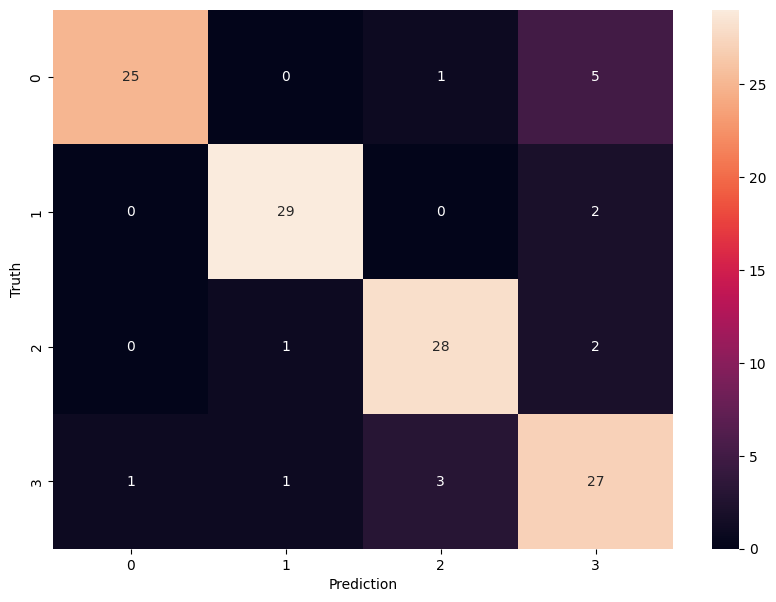

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 0])

Random Forest Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('random_forest', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0, 2],
    'random_forest__n_estimators': [50, 200, 500],
    'random_forest__max_depth': [None, 10, 20]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'random_forest__max_depth': 10, 'random_forest__n_estimators': 500, 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        31
           1       0.90      0.90      0.90        31
           2       0.83      0.94      0.88        31
           3       0.80      0.88      0.84        32

    accuracy                           0.86       125
   macro avg       0.87      0.86      0.86       125
weighted avg       0.87      0.86      0.86       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

KNN Model

In [ ]:
# Define a pipeline object
pipeline = Pipeline([
     ('vectorizer_tfidf', TfidfVectorizer()),
     ('knn', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'vectorizer_tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectorizer_tfidf__max_df': [0.75, 1.0],
    'knn__n_neighbors': [3, 4, 5, 6, 7, 8],
    'knn__weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model with X_train and y_train
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the predictions for X_test and store it in y_pred
y_pred = grid_search.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Best parameters found:  {'knn__n_neighbors': 7, 'knn__weights': 'distance', 'vectorizer_tfidf__max_df': 0.75, 'vectorizer_tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        31
           1       0.94      0.94      0.94        31
           2       0.82      0.87      0.84        31
           3       0.74      0.78      0.76        32

    accuracy                           0.84       125
   macro avg       0.84      0.84      0.84       125
weighted avg       0.84      0.84      0.84       125



In [ ]:
y_pred[:5]

array([2, 0, 1, 0, 2])

Model Testing on unseen data

In [2]:
import pandas as pd

# Example job posts
data = [
    {
        "Category": "Sales",
        "Title": "Sales Representative - Regional Accounts",
        "Webindex": "72635563",
        "Company": "National Sales Corp",
        "Description": "sales representative regional accounts client relationship management territory sales target achievement lead generation product demonstrations customer feedback market analysis sales strategy teamwork communication skills minimum bachelor business administration bba proven sales track record regional sales national sales corp career opportunity benefits package apply send resume visit website url removed"
    },
    {
        "Category": "Engineering",
        "Title": "Mechanical Design Engineer",
        "Webindex": "72635560",
        "Company": "Innovative Engineering Solutions",
        "Description": "mechanical design engineer responsible developing innovative mechanical systems solutions collaborate cross functional teams ensure product quality efficiency extensive knowledge cad software solidworks autocad experience mechanical design analysis simulation stress testing required minimum bachelor's degree mechanical engineering strong problem solving communication skills competitive salary benefits package apply send resume company email visit website"
    },
    {
        "Category": "Accounting_Finance",
        "Title": "Senior Financial Analyst",
        "Webindex": "72635562",
        "Company": "Global Financial Services",
        "Description": "senior financial analyst budgeting forecasting financial planning reporting financial statements variance analysis accounting gaap regulations financial modeling investment analysis strategic planning teamwork leadership skills excel sap minimum cpa mba preferred financial services global company structured benefits package send resume apply position online visit website url removed"
    },
    {
        "Category": "Healthcare_Nursing",
        "Title": "Registered Nurse - Intensive Care Unit",
        "Webindex": "72635561",
        "Company": "Healthcare Professionals",
        "Description": "registered nurse icu intensive care unit critical patient monitoring vital signs administering medications patient care plans healthcare professionals team environment shift rotations extensive benefits experience icu nursing registered nurse license state requirements minimum bachelor nursing bsn apply position send cv email website contact online healthcare professionals url removed"
    }
]

# Create DataFrame
df_examples = pd.DataFrame(data)

# Display DataFrame
df_examples


,Category,Title,Webindex,Company,Description
0,Sales,Sales Representative - Regional Accounts,72635563,National Sales Corp,sales representative regional accounts client ...
1,Engineering,Mechanical Design Engineer,72635560,Innovative Engineering Solutions,mechanical design engineer responsible develop...
2,Accounting_Finance,Senior Financial Analyst,72635562,Global Financial Services,senior financial analyst budgeting forecasting...
3,Healthcare_Nursing,Registered Nurse - Intensive Care Unit,72635561,Healthcare Professionals,registered nurse icu intensive care unit criti...


In [6]:
df_examples['Preprocessed_Description'] = df_examples['Description'].apply(preprocess)

In [7]:
df_examples['Preprocessed_Title'] = df_examples['Title'].apply(preprocess_title)

In [8]:
df_examples['Preprocessed_Title_Description']=df_examples['Preprocessed_Title']+ " " + df_examples['Preprocessed_Description']

In [9]:
df_examples

,Category,Title,Webindex,Company,Description,Preprocessed_Description,Preprocessed_Title,Preprocessed_Title_Description
0,Sales,Sales Representative - Regional Accounts,72635563,National Sales Corp,sales representative regional accounts client ...,sale representative regional account client re...,sale representative regional accounts,sale representative regional accounts sale rep...
1,Engineering,Mechanical Design Engineer,72635560,Innovative Engineering Solutions,mechanical design engineer responsible develop...,mechanical design engineer responsible develop...,mechanical design engineer,mechanical design engineer mechanical design e...
2,Accounting_Finance,Senior Financial Analyst,72635562,Global Financial Services,senior financial analyst budgeting forecasting...,senior financial analyst budgeting forecast fi...,senior financial analyst,senior financial analyst senior financial anal...
3,Healthcare_Nursing,Registered Nurse - Intensive Care Unit,72635561,Healthcare Professionals,registered nurse icu intensive care unit criti...,register nurse icu intensive care unit critica...,registered nurse intensive care unit,registered nurse intensive care unit register ...


In [10]:
from joblib import load

model1 = load('/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/MultinomialNB_CountVectorizer_model.joblib')

In [11]:
y_pred_examples = model1.predict(df_examples['Preprocessed_Title_Description'])

In [12]:
y_pred_examples

array([3, 0, 2, 1])

In [13]:
model2 = load('/content/drive/MyDrive/Natural Language Processing/Assignment5_Solution/SVC_tfidf_model.joblib')

In [14]:
y_pred_examples = model2.predict(df_examples['Preprocessed_Title_Description'])

In [15]:
y_pred_examples

array([3, 0, 2, 1])